In [2]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data as data
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from transformers import XLMRobertaTokenizerFast, XLMRobertaModel, AutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

ROOT_DIR = "/home/zhangshuhao/projects/ys/Graduate"
DATASET_PATH = os.path.join(ROOT_DIR, "dataset/pheme_source.csv")
LOCAL_ROBERTA_PATH = os.path.join(ROOT_DIR, 'model/hpm_adm_dual/roberta-base')
LOCAL_FAKEBERTA_PATH = os.path.join(ROOT_DIR, 'model/FakeBerta')

sys.path.append(os.path.join(ROOT_DIR, 'model/hpm_adm_dual'))
# Import the dual model
from hpm_adm_dual.model import DualChannelModel
from hpm_adm_dual.utils import *

print("✓ All imports successful")
print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

/home/zhangshuhao/miniconda3/envs/ys_gradproj_py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All imports successful
Using device: cuda


In [3]:
# Load the trained dual model
print("Loading trained dual model...")
tokenizer = XLMRobertaTokenizerFast.from_pretrained(LOCAL_ROBERTA_PATH)
model = DualChannelModel()

# Try to load the best model
model_path = os.path.join(ROOT_DIR, 'model/hpm_adm_dual/hpm_adm_dual/best_model20251025_20epoch_loss0.1194_mse0.0101_auc0.9736.pth')
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    print("✓ Model loaded successfully")
else:
    print("❌ Model file not found. Please train the model first.")
    print(f"Looking for: {model_path}")

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Model loaded on device: {device}")

Loading trained dual model...
✓ Model loaded successfully
Model loaded on device: cuda


In [4]:
# Load the pretrained baseline model (FakeBerta)
print("Loading trained FakeBerta model...")
tokenizer_fakeberta = AutoTokenizer.from_pretrained(LOCAL_FAKEBERTA_PATH)
model_fakeberta = AutoModelForSequenceClassification.from_pretrained(LOCAL_FAKEBERTA_PATH)

model_fakeberta.to(device)

print(f"Model loaded on device: {device}")

Loading trained FakeBerta model...
Model loaded on device: cuda


In [5]:
# inputs_fb = tokenizer_fakeberta("Breaking: Scientists discover water on Mars!", return_tensors="pt").to(device)
# outputs = model_fakeberta(**inputs_fb)

# logits_fb = outputs.logits
# print(outputs.logits)
# print(torch.argmax(logits_fb))
# predicted_class_fb = torch.argmax(logits_fb).item()
# print(predicted_class_fb)

In [6]:
# Function to extract RoBERTa features only (for traditional ML comparison)
def extract_roberta_features(texts, batch_size=32):
    """
    Extract only RoBERTa features for traditional ML models
    Returns: (roberta_features, hpm_predictions, adm_predictions)
    """
    model.eval()
    roberta_features = []
    hpm_predictions = []
    adm_predictions = []
    adm_predictions_fakeberta = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Extracting RoBERTa features"):
            batch_texts = texts[i:i+batch_size]
            
            # Tokenize the entire batch at once to ensure consistent padding
            inputs = tokenizer(
                batch_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=128
            )

            # fakeberta tokenizer
            inputs_fakeberta = tokenizer_fakeberta(
                batch_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=128
            )
            
            # Get emotion features for each text
            batch_emotion_features = []
            for text in batch_texts:
                emotion_feat = get_emotion_features(text)
                batch_emotion_features.append(emotion_feat)
            
            # Move to device
            input_ids = inputs["input_ids"].to(device)
            attention_masks = inputs["attention_mask"].to(device)
            emotion_features = torch.stack(batch_emotion_features).to(device)

            input_ids_fakeberta = inputs_fakeberta["input_ids"].to(device)
            attention_masks_fakeberta = inputs_fakeberta["attention_mask"].to(device)
            
            # Get model outputs
            hpm_pred, adm_pred = model(input_ids, attention_masks, emotion_features)
            adm_pred_fakeberta = torch.argmax(model_fakeberta(input_ids_fakeberta, attention_masks_fakeberta).logits, dim=1).unsqueeze(1)
            # print(adm_pred.shape)
            # print(adm_pred_fakeberta.shape)
            
            # Extract ONLY pretrained RoBERTa features (no LSTM, no emotion features)
            roberta_model = XLMRobertaModel.from_pretrained(LOCAL_ROBERTA_PATH).to(device)
            roberta_output = roberta_model(input_ids=input_ids, attention_mask=attention_masks)
            # Use [CLS] token representation (first token)
            roberta_feat = roberta_output.last_hidden_state[:, 0, :]  # [CLS] token
            
            # Store features and predictions
            roberta_features.append(roberta_feat.cpu().numpy())
            hpm_predictions.append(hpm_pred.cpu().numpy())
            adm_predictions.append(adm_pred.cpu().numpy())
            adm_predictions_fakeberta.append(adm_pred_fakeberta.cpu().numpy())
    
    # Concatenate all batches
    roberta_features = np.vstack(roberta_features)
    hpm_predictions = np.vstack(hpm_predictions).flatten()
    adm_predictions = np.vstack(adm_predictions).flatten()
    adm_predictions_fakeberta = np.vstack(adm_predictions_fakeberta).flatten()
    
    return roberta_features, hpm_predictions, adm_predictions, adm_predictions_fakeberta

print("✓ RoBERTa feature extraction function defined")


✓ RoBERTa feature extraction function defined


In [7]:
# Load and prepare PHEME dataset
print("Loading PHEME dataset...")
df = load_and_preprocess_data()
df = encode_labels(df)

print(f"Dataset shape: {df.shape}")
print(f"Veracity label distribution:")
print(df['veracity_label'].value_counts())
print(f"Retweet intensity stats:")
print(df['retweet_intensity'].describe())

# Create binary classification for ADM (true=1, false=0)
# For HPM, we'll use retweet_intensity as regression target
hpm_labels = df['retweet_intensity_normalized'].values
adm_labels = df['veracity_encoded'].values
texts = df['text_clean'].fillna('').astype(str).tolist()

print(f"\nHPM labels (retweet intensity) - Min: {hpm_labels.min():.4f}, Max: {hpm_labels.max():.4f}")
print(f"ADM labels - True: {np.sum(adm_labels)}, False: {np.sum(1-adm_labels)}")

# Split data for evaluation
X_train_texts, X_test_texts, y_train_hpm, y_test_hpm, y_train_adm, y_test_adm = train_test_split(
    texts, hpm_labels, adm_labels, test_size=0.2, random_state=42, stratify=adm_labels
)

print(f"\nTrain set: {len(X_train_texts)} samples")
print(f"Test set: {len(X_test_texts)} samples")
print(f"Train ADM distribution - True: {np.sum(y_train_adm)}, False: {np.sum(1-y_train_adm)}")
print(f"Test ADM distribution - True: {np.sum(y_test_adm)}, False: {np.sum(1-y_test_adm)}")


Loading PHEME dataset...
Loading dataset...
Dataset loaded: 5728 samples
Veracity labels distribution:
veracity_label
true     5090
false     638
Name: count, dtype: int64
Dataset shape: (5728, 23)
Veracity label distribution:
veracity_label
true     5090
false     638
Name: count, dtype: int64
Retweet intensity stats:
count    5728.000000
mean        0.552627
std         0.144151
min         0.075257
25%         0.517041
50%         0.557606
75%         0.623532
max         1.000000
Name: retweet_intensity, dtype: float64

HPM labels (retweet intensity) - Min: 0.0753, Max: 1.0000
ADM labels - True: 5090, False: 638

Train set: 4582 samples
Test set: 1146 samples
Train ADM distribution - True: 4072, False: 510
Test ADM distribution - True: 1018, False: 128


In [8]:
# Extract RoBERTa features for traditional ML models
print("Extracting RoBERTa features for traditional ML comparison...")

# Extract features for training set
print("Processing training set...")
X_train_roberta, train_hpm_pred, train_adm_pred, train_adm_pred_fakeberta = extract_roberta_features(X_train_texts)

# Extract features for test set
print("Processing test set...")
X_test_roberta, test_hpm_pred, test_adm_pred, test_adm_pred_fakeberta = extract_roberta_features(X_test_texts)

print(f"✓ RoBERTa feature extraction completed")
print(f"RoBERTa features shape: {X_train_roberta.shape}")

# Scale features for better performance
scaler_roberta = StandardScaler()

X_train_roberta_scaled = scaler_roberta.fit_transform(X_train_roberta)
X_test_roberta_scaled = scaler_roberta.transform(X_test_roberta)

print("✓ RoBERTa features scaled using StandardScaler")


Extracting RoBERTa features for traditional ML comparison...
Processing training set...


Extracting RoBERTa features:   0%|          | 0/144 [00:03<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 734.00 MiB. GPU 0 has a total capacity of 31.73 GiB of which 726.25 MiB is free. Process 1049223 has 858.00 MiB memory in use. Process 461527 has 1.93 GiB memory in use. Process 3482393 has 26.43 GiB memory in use. Including non-PyTorch memory, this process has 1.80 GiB memory in use. Of the allocated memory 1.37 GiB is allocated by PyTorch, and 62.65 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Train traditional ML models using RoBERTa features
print("Training traditional ML models using RoBERTa features...")

# Initialize classifiers for ADM task
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Train classifiers for ADM task (veracity classification)
print("\n=== Training ADM Classifiers (Veracity Classification) ===")
print("Using RoBERTa [CLS] token features only")
adm_models = {}
adm_results = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name} for ADM...")
    
    # Train the model using RoBERTa features
    clf.fit(X_train_roberta_scaled, y_train_adm)
    adm_models[name] = clf
    
    # Make predictions
    y_pred = clf.predict(X_test_roberta_scaled)
    y_pred_proba = clf.predict_proba(X_test_roberta_scaled)[:, 1] if hasattr(clf, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_adm, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_adm, y_pred, average='binary')
    auc = roc_auc_score(y_test_adm, y_pred_proba) if y_pred_proba is not None else None
    
    adm_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    if auc is not None:
        print(f"  AUC: {auc:.4f}")

print("\n✓ ADM classifiers training completed")


Training traditional ML models using RoBERTa features...

=== Training ADM Classifiers (Veracity Classification) ===
Using RoBERTa [CLS] token features only

Training Logistic Regression for ADM...
  Accuracy: 0.9258
  Precision: 0.9605
  Recall: 0.9558
  F1-Score: 0.9581
  AUC: 0.9270

Training SVM for ADM...
  Accuracy: 0.9389
  Precision: 0.9373
  Recall: 0.9980
  F1-Score: 0.9667
  AUC: 0.9594

Training Random Forest for ADM...
  Accuracy: 0.9171
  Precision: 0.9154
  Recall: 0.9990
  F1-Score: 0.9554
  AUC: 0.8780

✓ ADM classifiers training completed


In [ ]:
# Train regression models for HPM task (retweet intensity prediction)
print("\n=== Training HPM Models (Retweet Intensity Prediction) ===")
print("Using RoBERTa [CLS] token features only")

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize regression models
regressors = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'SVR': SVR(),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100)
}

hpm_models = {}
hpm_results = {}

for name, reg in regressors.items():
    print(f"\nTraining {name} for HPM...")
    
    # Train the model using RoBERTa features
    reg.fit(X_train_roberta_scaled, y_train_hpm)
    hpm_models[name] = reg
    
    # Make predictions
    y_pred = reg.predict(X_test_roberta_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test_hpm, y_pred)
    mae = mean_absolute_error(y_test_hpm, y_pred)
    r2 = r2_score(y_test_hpm, y_pred)
    rmse = np.sqrt(mse)
    
    hpm_results[name] = {
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'rmse': rmse,
        'predictions': y_pred
    }
    
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")

print("\n✓ HPM models training completed")



=== Training HPM Models (Retweet Intensity Prediction) ===
Using RoBERTa [CLS] token features only

Training Linear Regression for HPM...
  MSE: 0.0115
  MAE: 0.0827
  R²: 0.4444
  RMSE: 0.1073

Training Ridge Regression for HPM...
  MSE: 0.0114
  MAE: 0.0824
  R²: 0.4480
  RMSE: 0.1069

Training Lasso Regression for HPM...
  MSE: 0.0207
  MAE: 0.0931
  R²: -0.0001
  RMSE: 0.1440

Training SVR for HPM...
  MSE: 0.0109
  MAE: 0.0815
  R²: 0.4724
  RMSE: 0.1046

Training Random Forest for HPM...
  MSE: 0.0115
  MAE: 0.0781
  R²: 0.4473
  RMSE: 0.1070

✓ HPM models training completed


In [ ]:
# Compare Dual Model with RoBERTa + Traditional ML Models
print("\n=== Model Comparison ===")
print("Comparing:")
print("1. Dual Model (RoBERTa + Attention + Emotion Features)")
print("2. RoBERTa + Logistic/SVM/RF (using only RoBERTa [CLS] features)")

# Evaluate Dual Model performance
print("\n--- Dual Model Performance ---")

# ADM (Veracity Classification) - Dual Model
dual_adm_accuracy = accuracy_score(y_test_adm, (test_adm_pred > 0.5).astype(int))
dual_adm_precision, dual_adm_recall, dual_adm_f1, _ = precision_recall_fscore_support(
    y_test_adm, (test_adm_pred > 0.5).astype(int), average='binary'
)
dual_adm_auc = roc_auc_score(y_test_adm, test_adm_pred)

fakeberta_adm_accuracy = accuracy_score(y_test_adm, (test_adm_pred_fakeberta < 0.5).astype(int))
fakeberta_adm_precision, fakeberta_adm_recall, fakeberta_adm_f1, _ = precision_recall_fscore_support(
    y_test_adm, (test_adm_pred_fakeberta < 0.5).astype(int), average='binary'
)
fakeberta_adm_auc = roc_auc_score(y_test_adm, (1 - test_adm_pred_fakeberta))

print(f"ADM (Veracity Classification):")
print(f"  Accuracy: {dual_adm_accuracy:.4f}")
print(f"  Precision: {dual_adm_precision:.4f}")
print(f"  Recall: {dual_adm_recall:.4f}")
print(f"  F1-Score: {dual_adm_f1:.4f}")
print(f"  AUC: {dual_adm_auc:.4f}")

print(f"ADM (Veracity Classification) Baseline:")
print(f"  Accuracy: {fakeberta_adm_accuracy:.4f}")
print(f"  Precision: {fakeberta_adm_precision:.4f}")
print(f"  Recall: {fakeberta_adm_recall:.4f}")
print(f"  F1-Score: {fakeberta_adm_f1:.4f}")
print(f"  AUC: {fakeberta_adm_auc:.4f}")

# HPM (Retweet Intensity Prediction) - Dual Model
dual_hpm_mse = mean_squared_error(y_test_hpm, test_hpm_pred)
dual_hpm_mae = mean_absolute_error(y_test_hpm, test_hpm_pred)
dual_hpm_r2 = r2_score(y_test_hpm, test_hpm_pred)
dual_hpm_rmse = np.sqrt(dual_hpm_mse)

print(f"\nHPM (Retweet Intensity Prediction):")
print(f"  MSE: {dual_hpm_mse:.4f}")
print(f"  MAE: {dual_hpm_mae:.4f}")
print(f"  R²: {dual_hpm_r2:.4f}")
print(f"  RMSE: {dual_hpm_rmse:.4f}")

# Create comparison tables
print("\n--- ADM Performance Comparison ---")
print("RoBERTa + Traditional ML vs Dual Model")
adm_comparison = pd.DataFrame({
    'Model': ['EAB-HHDP(ADM)', 'FakeBerta'] + list(adm_results.keys()),
    'Architecture': ['RoBERTa + Attention + Emotion', 'Finetuned RoBERTa'] + ['RoBERTa + ' + name for name in adm_results.keys()],
    'Accuracy': [dual_adm_accuracy, fakeberta_adm_accuracy] + [adm_results[name]['accuracy'] for name in adm_results.keys()],
    'Precision': [dual_adm_precision, fakeberta_adm_precision] + [adm_results[name]['precision'] for name in adm_results.keys()],
    'Recall': [dual_adm_recall, fakeberta_adm_recall] + [adm_results[name]['recall'] for name in adm_results.keys()],
    'F1-Score': [dual_adm_f1, fakeberta_adm_f1] + [adm_results[name]['f1'] for name in adm_results.keys()],
    'AUC': [dual_adm_auc, fakeberta_adm_auc] + [adm_results[name]['auc'] for name in adm_results.keys()]
})

print(adm_comparison.round(4))

print("\n--- HPM Performance Comparison ---")
print("RoBERTa + Traditional ML vs Dual Model")
hpm_comparison = pd.DataFrame({
    'Model': ['EAB-HHDP(HPM)'] + list(hpm_results.keys()),
    'Architecture': ['RoBERTa + Attention + Emotion'] + ['RoBERTa + ' + name for name in hpm_results.keys()],
    'MSE': [dual_hpm_mse] + [hpm_results[name]['mse'] for name in hpm_results.keys()],
    'MAE': [dual_hpm_mae] + [hpm_results[name]['mae'] for name in hpm_results.keys()],
    'R²': [dual_hpm_r2] + [hpm_results[name]['r2'] for name in hpm_results.keys()],
    'RMSE': [dual_hpm_rmse] + [hpm_results[name]['rmse'] for name in hpm_results.keys()]
})

print(hpm_comparison.round(4))



=== Model Comparison ===
Comparing:
1. Dual Model (RoBERTa + Attention + Emotion Features)
2. RoBERTa + Logistic/SVM/RF (using only RoBERTa [CLS] features)

--- Dual Model Performance ---
ADM (Veracity Classification):
  Accuracy: 0.9668
  Precision: 0.9795
  Recall: 0.9833
  F1-Score: 0.9814
  AUC: 0.9810
ADM (Veracity Classification) Baseline:
  Accuracy: 0.8578
  Precision: 0.8918
  Recall: 0.9558
  F1-Score: 0.9227
  AUC: 0.5170

HPM (Retweet Intensity Prediction):
  MSE: 0.0096
  MAE: 0.0756
  R²: 0.5368
  RMSE: 0.0980

--- ADM Performance Comparison ---
RoBERTa + Traditional ML vs Dual Model
                 Model                   Architecture  Accuracy  Precision  \
0        EAB-HHDP(ADM)  RoBERTa + Attention + Emotion    0.9668     0.9795   
1            FakeBerta              Finetuned RoBERTa    0.8578     0.8918   
2  Logistic Regression  RoBERTa + Logistic Regression    0.9258     0.9605   
3                  SVM                  RoBERTa + SVM    0.9389     0.9373   
4   

In [ ]:
hpm_comparison.round(4)

,Model,Architecture,MSE,MAE,R²,RMSE
0,EAB-HHDP(HPM),RoBERTa + Attention + Emotion,0.0096,0.0756,0.5368,0.0980
1,Linear Regression,RoBERTa + Linear Regression,0.0115,0.0827,0.4444,0.1073
2,Ridge Regression,RoBERTa + Ridge Regression,0.0114,0.0824,0.4480,0.1069
3,Lasso Regression,RoBERTa + Lasso Regression,0.0207,0.0931,-0.0001,0.1440
4,SVR,RoBERTa + SVR,0.0109,0.0815,0.4724,0.1046
5,Random Forest,RoBERTa + Random Forest,0.0115,0.0781,0.4473,0.1070


In [ ]:
adm_comparison.round(4)

,Model,Architecture,Accuracy,Precision,Recall,F1-Score,AUC
0,EAB-HHDP(ADM),RoBERTa + Attention + Emotion,0.9668,0.9795,0.9833,0.9814,0.9810
1,FakeBerta,Finetuned RoBERTa,0.8578,0.8918,0.9558,0.9227,0.5170
2,Logistic Regression,RoBERTa + Logistic Regression,0.9258,0.9605,0.9558,0.9581,0.9270
3,SVM,RoBERTa + SVM,0.9389,0.9373,0.9980,0.9667,0.9594
4,Random Forest,RoBERTa + Random Forest,0.9171,0.9154,0.9990,0.9554,0.8780


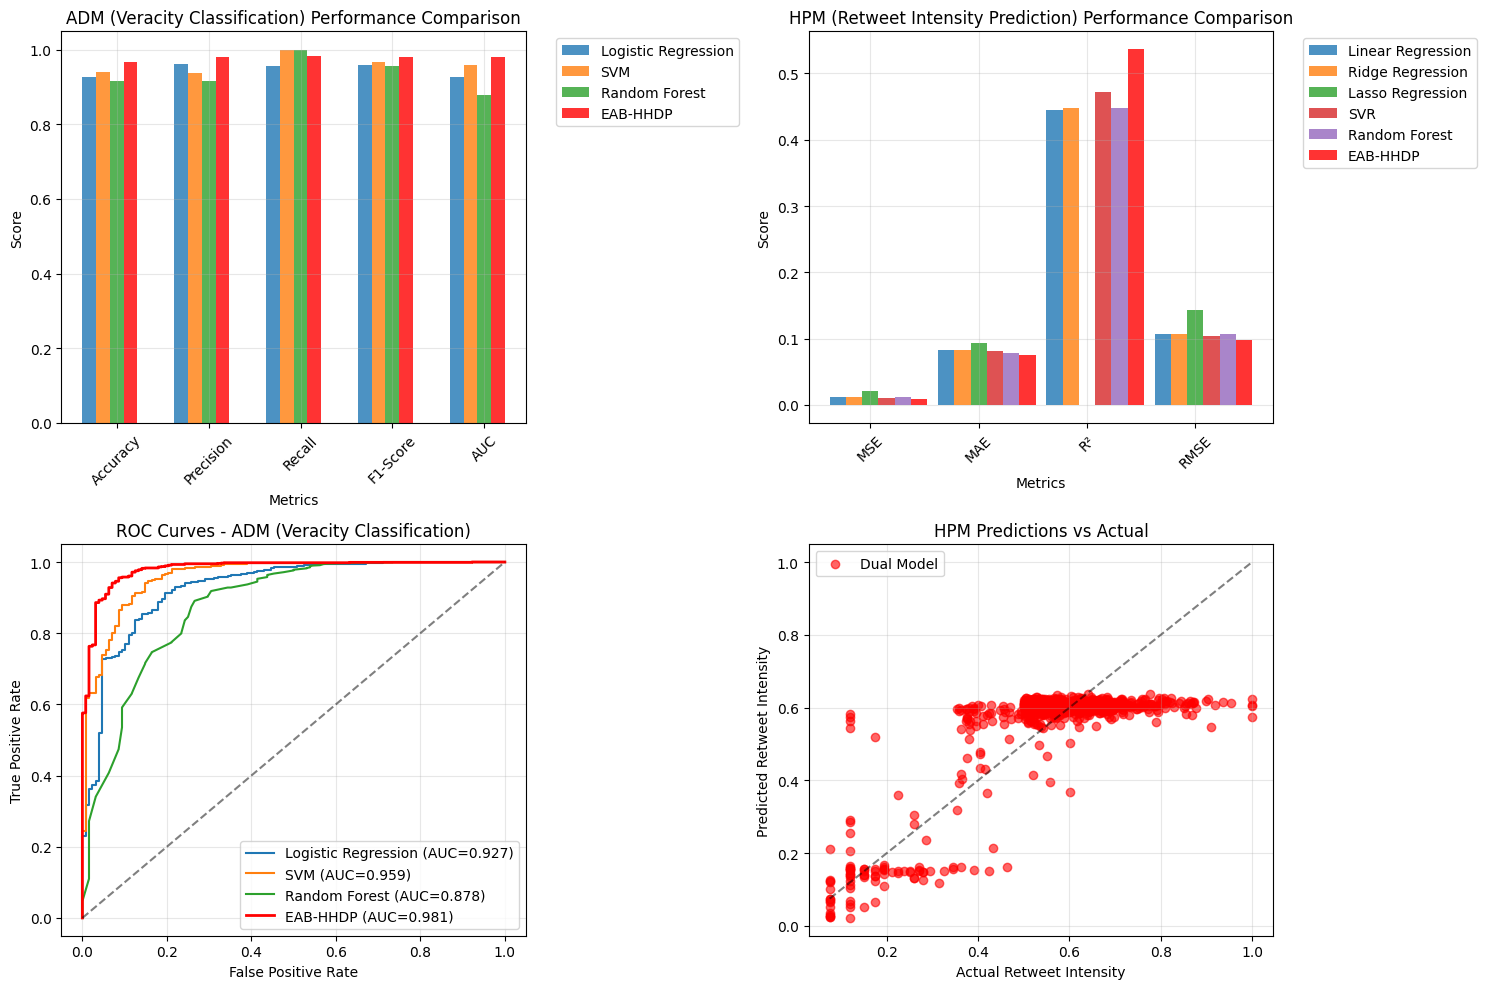

In [ ]:
# Visualization 1: ADM Performance Comparison
plt.figure(figsize=(15, 10))

# ADM Metrics Comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(metrics))
width = 0.15

plt.subplot(2, 2, 1)
for i, (model, results) in enumerate(adm_results.items()):
    values = [results['accuracy'], results['precision'], results['recall'], results['f1'], results['auc']]
    plt.bar(x + i*width, values, width, label=model, alpha=0.8)

# Add Dual Model
dual_values = [dual_adm_accuracy, dual_adm_precision, dual_adm_recall, dual_adm_f1, dual_adm_auc]
plt.bar(x + len(adm_results)*width, dual_values, width, label='EAB-HHDP', alpha=0.8, color='red')

# fakeberta_values = [fakeberta_adm_accuracy, fakeberta_adm_precision, fakeberta_adm_recall, fakeberta_adm_f1, fakeberta_adm_auc]
# plt.bar(x + (len(adm_results) + 1)*width, fakeberta_values, width, label='FakeBerta', alpha=0.8, color='purple')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('ADM (Veracity Classification) Performance Comparison')
plt.xticks(x + width*2, metrics, rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# HPM Metrics Comparison
plt.subplot(2, 2, 2)
hpm_metrics = ['MSE', 'MAE', 'R²', 'RMSE']
x_hpm = np.arange(len(hpm_metrics))

for i, (model, results) in enumerate(hpm_results.items()):
    values = [results['mse'], results['mae'], results['r2'], results['rmse']]
    plt.bar(x_hpm + i*width, values, width, label=model, alpha=0.8)

# Add Dual Model
dual_hpm_values = [dual_hpm_mse, dual_hpm_mae, dual_hpm_r2, dual_hpm_rmse]
plt.bar(x_hpm + len(hpm_results)*width, dual_hpm_values, width, label='EAB-HHDP', alpha=0.8, color='red')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('HPM (Retweet Intensity Prediction) Performance Comparison')
plt.xticks(x_hpm + width*2, hpm_metrics, rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# ROC Curve for ADM
plt.subplot(2, 2, 3)
from sklearn.metrics import roc_curve

for name, results in adm_results.items():
    if results['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test_adm, results['probabilities'])
        plt.plot(fpr, tpr, label=f'{name} (AUC={results["auc"]:.3f})')

# Dual Model ROC
fpr_dual, tpr_dual, _ = roc_curve(y_test_adm, test_adm_pred)
plt.plot(fpr_dual, tpr_dual, label=f'EAB-HHDP (AUC={dual_adm_auc:.3f})', color='red', linewidth=2)

# fpr_fakeberta, tpr_fakeberta, _ = roc_curve(y_test_adm, (1 - test_adm_pred_fakeberta))
# plt.plot(fpr_fakeberta, tpr_fakeberta, label=f'FakeBerta (AUC={fakeberta_adm_auc:.3f})', color='purple', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - ADM (Veracity Classification)')
plt.legend()
plt.grid(True, alpha=0.3)

# Prediction vs Actual for HPM
plt.subplot(2, 2, 4)
plt.scatter(y_test_hpm, test_hpm_pred, alpha=0.6, label='Dual Model', color='red')
plt.plot([y_test_hpm.min(), y_test_hpm.max()], [y_test_hpm.min(), y_test_hpm.max()], 'k--', alpha=0.5)
plt.xlabel('Actual Retweet Intensity')
plt.ylabel('Predicted Retweet Intensity')
plt.title('HPM Predictions vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


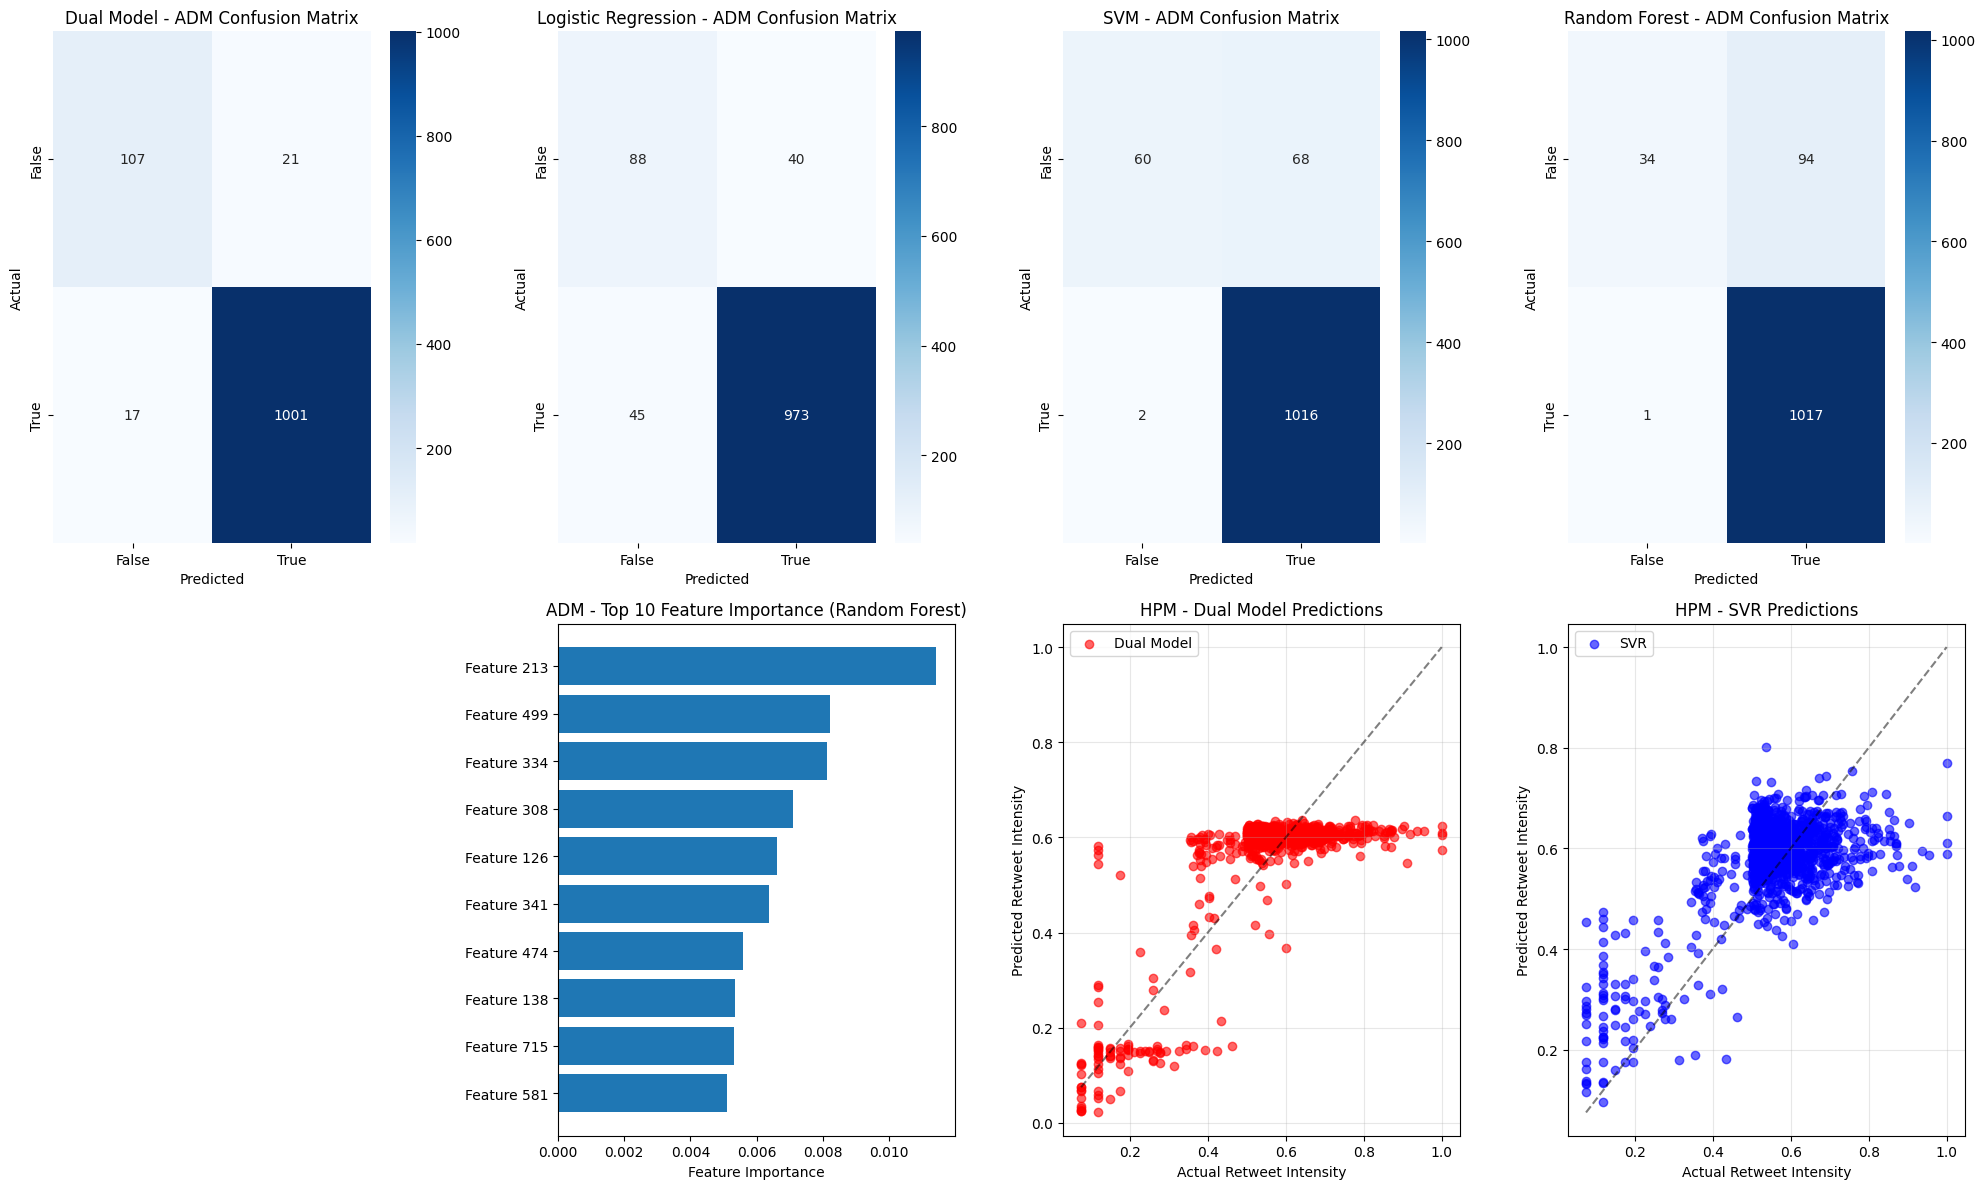

In [ ]:
# Visualization 2: Confusion Matrices and Detailed Analysis
plt.figure(figsize=(20, 12))

# Confusion Matrices for ADM
plt.subplot(2, 4, 1)
cm_dual = confusion_matrix(y_test_adm, (test_adm_pred > 0.5).astype(int))
sns.heatmap(cm_dual, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.title('Dual Model - ADM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Confusion matrices for traditional models
for i, (name, results) in enumerate(adm_results.items()):
    plt.subplot(2, 4, i+2)
    cm = confusion_matrix(y_test_adm, results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.title(f'{name} - ADM Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

# Feature Importance Analysis (Random Forest)
plt.subplot(2, 4, 6)
if 'Random Forest' in adm_models:
    feature_importance = adm_models['Random Forest'].feature_importances_
    top_features = np.argsort(feature_importance)[-10:]  # Top 10 features
    plt.barh(range(len(top_features)), feature_importance[top_features])
    plt.yticks(range(len(top_features)), [f'Feature {i}' for i in top_features])
    plt.xlabel('Feature Importance')
    plt.title('ADM - Top 10 Feature Importance (Random Forest)')

# HPM Prediction Scatter Plots
plt.subplot(2, 4, 7)
plt.scatter(y_test_hpm, test_hpm_pred, alpha=0.6, color='red', label='Dual Model')
plt.plot([y_test_hpm.min(), y_test_hpm.max()], [y_test_hpm.min(), y_test_hpm.max()], 'k--', alpha=0.5)
plt.xlabel('Actual Retweet Intensity')
plt.ylabel('Predicted Retweet Intensity')
plt.title('HPM - Dual Model Predictions')
plt.legend()
plt.grid(True, alpha=0.3)

# Best Traditional Model for HPM
best_hpm_model = min(hpm_results.keys(), key=lambda x: hpm_results[x]['mse'])
plt.subplot(2, 4, 8)
plt.scatter(y_test_hpm, hpm_results[best_hpm_model]['predictions'], alpha=0.6, color='blue', label=best_hpm_model)
plt.plot([y_test_hpm.min(), y_test_hpm.max()], [y_test_hpm.min(), y_test_hpm.max()], 'k--', alpha=0.5)
plt.xlabel('Actual Retweet Intensity')
plt.ylabel('Predicted Retweet Intensity')
plt.title(f'HPM - {best_hpm_model} Predictions')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# # Statistical Analysis and Summary
# print("=== STATISTICAL ANALYSIS AND SUMMARY ===\n")

# # Find best performing models
# best_adm_model = max(adm_results.keys(), key=lambda x: adm_results[x]['auc'])
# best_hpm_model = min(hpm_results.keys(), key=lambda x: hpm_results[x]['mse'])

# print(f"🏆 Best ADM Model: {best_adm_model} (AUC: {adm_results[best_adm_model]['auc']:.4f})")
# print(f"🏆 Best HPM Model: {best_hpm_model} (MSE: {hpm_results[best_hpm_model]['mse']:.4f})")

# # Performance comparison with Dual Model
# print(f"\n📊 Dual Model vs Best Traditional Models:")
# print(f"ADM AUC - Dual: {dual_adm_auc:.4f} vs {best_adm_model}: {adm_results[best_adm_model]['auc']:.4f}")
# print(f"HPM MSE - Dual: {dual_hpm_mse:.4f} vs {best_hpm_model}: {hpm_results[best_hpm_model]['mse']:.4f}")

# # Statistical significance testing (if possible)
# from scipy import stats

# print(f"\n📈 Statistical Significance Tests:")

# # ADM AUC comparison
# if len(y_test_adm) > 30:  # Only if we have enough samples
#     try:
#         # Compare Dual Model vs best traditional model for ADM
#         dual_adm_pred_binary = (test_adm_pred > 0.5).astype(int)
#         best_adm_pred = adm_results[best_adm_model]['predictions']
        
#         # McNemar's test for paired binary classification
#         from statsmodels.stats.contingency_tables import mcnemar
#         contingency_table = np.array([[np.sum((dual_adm_pred_binary == 1) & (best_adm_pred == 1)),
#                                      np.sum((dual_adm_pred_binary == 1) & (best_adm_pred == 0))],
#                                     [np.sum((dual_adm_pred_binary == 0) & (best_adm_pred == 1)),
#                                      np.sum((dual_adm_pred_binary == 0) & (best_adm_pred == 0))]])
        
#         result = mcnemar(contingency_table, exact=True)
#         print(f"ADM McNemar's test p-value: {result.pvalue:.4f}")
        
#         if result.pvalue < 0.05:
#             print("  → Significant difference between Dual Model and best traditional model")
#         else:
#             print("  → No significant difference between Dual Model and best traditional model")
#     except Exception as e:
#         print(f"  → Could not perform statistical test: {e}")

# # HPM correlation analysis
# dual_hpm_corr = np.corrcoef(y_test_hpm, test_hpm_pred)[0, 1]
# best_hpm_corr = np.corrcoef(y_test_hpm, hpm_results[best_hpm_model]['predictions'])[0, 1]

# print(f"HPM Correlation - Dual: {dual_hpm_corr:.4f}, {best_hpm_model}: {best_hpm_corr:.4f}")

# # Cross-validation scores for robustness
# print(f"\n🔄 Cross-Validation Analysis:")
# print("Using RoBERTa [CLS] features for traditional ML models")

# # 5-fold CV for ADM
# cv_scores_adm = {}
# for name, clf in adm_models.items():
#     cv_scores = cross_val_score(clf, X_train_roberta_scaled, y_train_adm, cv=5, scoring='roc_auc')
#     cv_scores_adm[name] = cv_scores
#     print(f"RoBERTa + {name} ADM CV AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# # 5-fold CV for HPM
# cv_scores_hpm = {}
# for name, reg in hpm_models.items():
#     cv_scores = cross_val_score(reg, X_train_roberta_scaled, y_train_hpm, cv=5, scoring='neg_mean_squared_error')
#     cv_scores_hpm[name] = -cv_scores  # Convert back to positive MSE
#     print(f"RoBERTa + {name} HPM CV MSE: {cv_scores_hpm[name].mean():.4f} ± {cv_scores_hpm[name].std():.4f}")

# # Final Summary
# print(f"\n📋 FINAL SUMMARY:")
# print(f"=" * 60)
# print(f"Dataset: PHEME ({len(df)} samples)")
# print(f"Train/Test Split: {len(X_train_texts)}/{len(X_test_texts)}")
# print(f"Features: RoBERTa [CLS] token ({X_train_roberta.shape[1]} dimensions)")
# print(f"\nComparison:")
# print(f"  Dual Model: RoBERTa + LSTM + Emotion Features")
# print(f"  Traditional ML: RoBERTa [CLS] + Logistic/SVM/RF")
# print(f"\nBest Traditional Models:")
# print(f"  ADM: RoBERTa + {best_adm_model} (AUC: {adm_results[best_adm_model]['auc']:.4f})")
# print(f"  HPM: RoBERTa + {best_hpm_model} (MSE: {hpm_results[best_hpm_model]['mse']:.4f})")
# print(f"\nDual Model Performance:")
# print(f"  ADM AUC: {dual_adm_auc:.4f}")
# print(f"  HPM MSE: {dual_hpm_mse:.4f}")
# print(f"  HPM R²: {dual_hpm_r2:.4f}")

# # Model ranking
# print(f"\n🏅 Model Rankings:")
# print(f"ADM (by AUC):")
# adm_ranking = sorted([(f'RoBERTa + {name}', results['auc']) for name, results in adm_results.items()] + 
#                     [('Dual Model', dual_adm_auc)], key=lambda x: x[1], reverse=True)
# for i, (name, score) in enumerate(adm_ranking, 1):
#     print(f"  {i}. {name}: {score:.4f}")

# print(f"\nHPM (by MSE - lower is better):")
# hpm_ranking = sorted([(f'RoBERTa + {name}', results['mse']) for name, results in hpm_results.items()] + 
#                     [('Dual Model', dual_hpm_mse)], key=lambda x: x[1])
# for i, (name, score) in enumerate(hpm_ranking, 1):
#     print(f"  {i}. {name}: {score:.4f}")

# print(f"\n✅ Evaluation completed successfully!")


In [ ]:
# # Save Results and Create Summary Report
# print("💾 Saving evaluation results...")

# # Create results directory
# results_dir = os.path.join(ROOT_DIR, 'model/hpm_adm_dual/evaluation_results')
# os.makedirs(results_dir, exist_ok=True)

# # Save detailed results to CSV
# adm_comparison.to_csv(os.path.join(results_dir, 'adm_performance_comparison.csv'), index=False)
# hpm_comparison.to_csv(os.path.join(results_dir, 'hpm_performance_comparison.csv'), index=False)

# # Save predictions for further analysis
# predictions_df = pd.DataFrame({
#     'text': X_test_texts,
#     'actual_adm': y_test_adm,
#     'actual_hpm': y_test_hpm,
#     'dual_adm_pred': test_adm_pred,
#     'dual_hpm_pred': test_hpm_pred,
#     'dual_adm_pred_binary': (test_adm_pred > 0.5).astype(int)
# })

# # Add traditional model predictions
# for name, results in adm_results.items():
#     predictions_df[f'{name}_adm_pred'] = results['predictions']
#     if results['probabilities'] is not None:
#         predictions_df[f'{name}_adm_prob'] = results['probabilities']

# for name, results in hpm_results.items():
#     predictions_df[f'{name}_hpm_pred'] = results['predictions']

# predictions_df.to_csv(os.path.join(results_dir, 'all_predictions.csv'), index=False)

# # Create summary report
# report = f"""
# # Dual Model Evaluation Report

# ## Dataset Information
# - **Dataset**: PHEME
# - **Total Samples**: {len(df)}
# - **Train/Test Split**: {len(X_train_texts)}/{len(X_test_texts)}
# - **Features**: HPM ({X_train_hpm_feat.shape[1]}), ADM ({X_train_adm_feat.shape[1]})

# ## Model Performance Summary

# ### ADM (Veracity Classification) - AUC Scores
# """
# for name, score in adm_ranking:
#     report += f"- {name}: {score:.4f}\n"

# report += f"""
# ### HPM (Retweet Intensity Prediction) - MSE Scores
# """
# for name, score in hpm_ranking:
#     report += f"- {name}: {score:.4f}\n"

# report += f"""
# ## Key Findings
# - **Best ADM Model**: {best_adm_model} (AUC: {adm_results[best_adm_model]['auc']:.4f})
# - **Best HPM Model**: {best_hpm_model} (MSE: {hpm_results[best_hpm_model]['mse']:.4f})
# - **Dual Model ADM AUC**: {dual_adm_auc:.4f}
# - **Dual Model HPM MSE**: {dual_hpm_mse:.4f}
# - **Dual Model HPM R²**: {dual_hpm_r2:.4f}

# ## Files Generated
# - `adm_performance_comparison.csv`: ADM performance metrics
# - `hpm_performance_comparison.csv`: HPM performance metrics  
# - `all_predictions.csv`: All model predictions for detailed analysis

# ## Evaluation Date
# {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
# """

# # Save report
# with open(os.path.join(results_dir, 'evaluation_report.md'), 'w') as f:
#     f.write(report)

# print(f"✅ Results saved to: {results_dir}")
# print(f"📄 Report saved: evaluation_report.md")
# print(f"📊 Data files saved: adm_performance_comparison.csv, hpm_performance_comparison.csv, all_predictions.csv")

# # Display final comparison table
# print(f"\n📋 FINAL PERFORMANCE COMPARISON")
# print(f"{'='*80}")
# print(f"{'Model':<20} {'ADM AUC':<10} {'HPM MSE':<10} {'HPM R²':<10}")
# print(f"{'='*80}")
# print(f"{'Dual Model':<20} {dual_adm_auc:<10.4f} {dual_hpm_mse:<10.4f} {dual_hpm_r2:<10.4f}")
# for name in adm_results.keys():
#     adm_score = adm_results[name]['auc']
#     hpm_score = hpm_results[name]['mse']
#     hpm_r2 = hpm_results[name]['r2']
#     print(f"{name:<20} {adm_score:<10.4f} {hpm_score:<10.4f} {hpm_r2:<10.4f}")

# print(f"\n🎉 Evaluation completed! Check the results directory for detailed analysis.")


In [11]:
# Load Arbitrator Model and Compare with enhanced Arbitrator
print("="*80)
print("Arbitrator vs Enhanced Arbitrator Model Comparison")
print("="*80)

# Import Arbitrator model
sys.path.append(os.path.join(ROOT_DIR, 'model/arbitrator'))
from arbitrator.model import Arbitrator
from arbitrator.dataset import ArbitratorDataset

# Load Arbitrator model
ARBITRATOR_MODEL_PATH = os.path.join(ROOT_DIR, 'model/arbitrator/arbitrator/base_model251206_loss0.1902_auc0.9738.pth')
ARBITRATOR_DATASET_PATH = os.path.join(ROOT_DIR, 'dataset/pheme_formatted_with_embeddings.csv')

# Load Enhanced Arbitrator model
ENHANCED_ARBITRATOR_MODEL_PATH = os.path.join(ROOT_DIR, 'model/enhanced_arbitrator/enhanced_arbitrator/enhanced_model1212_acc0.9905_auc0.9985_fakeacc0.9371.pth')

# Model parameters
EMOTION_EMB_DIM = 28
TEXT_EMB_DIM = 768
PROPAGATION_PROB_DIM = 1
FAKE_NEWS_PROB_DIM = 1
STATE_DIM = EMOTION_EMB_DIM + TEXT_EMB_DIM + PROPAGATION_PROB_DIM + FAKE_NEWS_PROB_DIM

print(f"\nLoading Arbitrator model from: {ARBITRATOR_MODEL_PATH}")
arbitrator_model = Arbitrator(state_dim=STATE_DIM, hidden_dim=512, action_dim=2)
if os.path.exists(ARBITRATOR_MODEL_PATH):
    arbitrator_model.load_state_dict(torch.load(ARBITRATOR_MODEL_PATH, map_location='cpu'))
    print("✓ Arbitrator model loaded successfully")
else:
    print(f"❌ Arbitrator model not found at: {ARBITRATOR_MODEL_PATH}")
    print("Please train the Arbitrator model first.")

arbitrator_model.eval()
arbitrator_model.to(device)
print(f"Arbitrator model loaded on device: {device}")

print(f"\nLoading Enhanced Arbitrator model from: {ENHANCED_ARBITRATOR_MODEL_PATH}")
enhanced_arbitrator_model = Arbitrator(state_dim=STATE_DIM, hidden_dim=512, action_dim=2)
if os.path.exists(ENHANCED_ARBITRATOR_MODEL_PATH):
    enhanced_arbitrator_model.load_state_dict(torch.load(ENHANCED_ARBITRATOR_MODEL_PATH, map_location='cpu'))
    print("✓ Enhanced Arbitrator model loaded successfully")
else:
    print(f"❌ Enhanced Arbitrator model not found at: {ENHANCED_ARBITRATOR_MODEL_PATH}")

enhanced_arbitrator_model.eval()
enhanced_arbitrator_model.to(device)
print(f"Enhanced Arbitrator model loaded on device: {device}")

# Load dataset with embeddings
print(f"\nLoading dataset from: {ARBITRATOR_DATASET_PATH}")
df_arbitrator = pd.read_csv(ARBITRATOR_DATASET_PATH)
print(f"Dataset shape: {df_arbitrator.shape}")

# Clean labels
def clean_label(x):
    if pd.isna(x):
        return 0
    x = int(float(x))
    return max(0, min(1, x))

df_arbitrator['veracity_label_id'] = df_arbitrator['veracity_label_id'].apply(clean_label)
print(f"Label distribution:\n{df_arbitrator['veracity_label_id'].value_counts().sort_index()}")

# Create Arbitrator dataset
arbitrator_dataset = ArbitratorDataset(df_arbitrator)
arbitrator_loader = data.DataLoader(arbitrator_dataset, batch_size=32, shuffle=False, num_workers=2)

print("✓ Dataset loaded and prepared")


Arbitrator vs Enhanced Arbitrator Model Comparison

Loading Arbitrator model from: /home/zhangshuhao/projects/ys/Graduate/model/arbitrator/arbitrator/base_model251206_loss0.1902_auc0.9738.pth
✓ Arbitrator model loaded successfully
Arbitrator model loaded on device: cuda

Loading Enhanced Arbitrator model from: /home/zhangshuhao/projects/ys/Graduate/model/enhanced_arbitrator/enhanced_arbitrator/enhanced_model1212_acc0.9905_auc0.9985_fakeacc0.9371.pth
✓ Enhanced Arbitrator model loaded successfully
Enhanced Arbitrator model loaded on device: cuda

Loading dataset from: /home/zhangshuhao/projects/ys/Graduate/dataset/pheme_formatted_with_embeddings.csv
Dataset shape: (6425, 25)
Label distribution:
veracity_label_id
0     638
1    5787
Name: count, dtype: int64
✓ Dataset loaded and prepared


In [12]:
# Evaluate Arbitrator model on whole dataset
print("\n" + "="*80)
print("Evaluating Arbitrator Model on Whole Dataset")
print("="*80)

arbitrator_model.eval()
arbitrator_predictions = []
arbitrator_probs = []
arbitrator_labels = []
arbitrator_states = []

with torch.no_grad():
    for batch in tqdm(arbitrator_loader, desc="Evaluating Arbitrator"):
        states = batch['state'].to(device)
        labels = batch['label'].to(device)
        
        logits = arbitrator_model(states)
        probs = F.softmax(logits, dim=-1)
        preds = torch.argmax(logits, dim=-1)
        
        arbitrator_predictions.extend(preds.cpu().numpy())
        arbitrator_probs.extend(probs.cpu().numpy())
        arbitrator_labels.extend(labels.cpu().numpy())
        arbitrator_states.extend(states.cpu().numpy())

arbitrator_predictions = np.array(arbitrator_predictions)
arbitrator_probs = np.array(arbitrator_probs)
arbitrator_labels = np.array(arbitrator_labels)

# Calculate metrics for Arbitrator
arbitrator_acc = accuracy_score(arbitrator_labels, arbitrator_predictions)
arbitrator_precision, arbitrator_recall, arbitrator_f1, _ = precision_recall_fscore_support(
    arbitrator_labels, arbitrator_predictions, average='binary', zero_division=0
)
arbitrator_auc = roc_auc_score(arbitrator_labels, arbitrator_probs[:, 1])

print(f"\nArbitrator Model Performance (Whole Dataset):")
print(f"  Accuracy: {arbitrator_acc:.4f}")
print(f"  Precision: {arbitrator_precision:.4f}")
print(f"  Recall: {arbitrator_recall:.4f}")
print(f"  F1-Score: {arbitrator_f1:.4f}")
print(f"  AUC: {arbitrator_auc:.4f}")

# Get Enhanced Arbitrator predictions
enhanced_arbitrator_model.eval()
enhanced_arbitrator_predictions = []
enhanced_arbitrator_probs = []
enhanced_arbitrator_labels = []
enhanced_arbitrator_states = []

with torch.no_grad():
    for batch in tqdm(arbitrator_loader, desc="Evaluating Arbitrator"):
        states = batch['state'].to(device)
        labels = batch['label'].to(device)
        
        logits = enhanced_arbitrator_model(states)
        probs = F.softmax(logits, dim=-1)
        preds = torch.argmax(logits, dim=-1)
        
        enhanced_arbitrator_predictions.extend(preds.cpu().numpy())
        enhanced_arbitrator_probs.extend(probs.cpu().numpy())
        enhanced_arbitrator_labels.extend(labels.cpu().numpy())
        enhanced_arbitrator_states.extend(states.cpu().numpy())

enhanced_arbitrator_predictions = np.array(enhanced_arbitrator_predictions)
enhanced_arbitrator_probs = np.array(enhanced_arbitrator_probs)
enhanced_arbitrator_labels = np.array(enhanced_arbitrator_labels)

# Calculate metrics for Arbitrator
enhanced_arbitrator_acc = accuracy_score(enhanced_arbitrator_labels, enhanced_arbitrator_predictions)
enhanced_arbitrator_precision, enhanced_arbitrator_recall, enhanced_arbitrator_f1, _ = precision_recall_fscore_support(
    enhanced_arbitrator_labels, enhanced_arbitrator_predictions, average='binary', zero_division=0
)
enhanced_arbitrator_auc = roc_auc_score(enhanced_arbitrator_labels, enhanced_arbitrator_probs[:, 1])

print(f"\nEnhanced Arbitrator Model Performance (Whole Dataset):")
print(f"  Accuracy: {enhanced_arbitrator_acc:.4f}")
print(f"  Precision: {enhanced_arbitrator_precision:.4f}")
print(f"  Recall: {enhanced_arbitrator_recall:.4f}")
print(f"  F1-Score: {enhanced_arbitrator_f1:.4f}")
print(f"  AUC: {enhanced_arbitrator_auc:.4f}")

# Create comparison table
comparison_whole = pd.DataFrame({
    'Model': ['Arbitrator', 'Enhanced Arbitrator'],
    'Accuracy': [arbitrator_acc, enhanced_arbitrator_acc],
    'Precision': [arbitrator_precision, enhanced_arbitrator_precision],
    'Recall': [arbitrator_recall, enhanced_arbitrator_recall],
    'F1-Score': [arbitrator_f1, enhanced_arbitrator_f1],
    'AUC': [arbitrator_auc, enhanced_arbitrator_auc]
})

print("\n" + "="*80)
print("Comparison: Arbitrator vs Enhanced Arbitrator (Whole Dataset)")
print("="*80)
print(comparison_whole.round(4))



Evaluating Arbitrator Model on Whole Dataset


Evaluating Arbitrator:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating Arbitrator: 100%|██████████| 201/201 [00:01<00:00, 122.93it/s]



Arbitrator Model Performance (Whole Dataset):
  Accuracy: 0.9847
  Precision: 0.9880
  Recall: 0.9952
  F1-Score: 0.9916
  AUC: 0.9890


Evaluating Arbitrator:   0%|          | 0/201 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating Arbitrator: 100%|██████████| 201/201 [00:01<00:00, 124.38it/s]


Enhanced Arbitrator Model Performance (Whole Dataset):
  Accuracy: 0.9905
  Precision: 0.9957
  Recall: 0.9938
  F1-Score: 0.9947
  AUC: 0.9985

Comparison: Arbitrator vs Enhanced Arbitrator (Whole Dataset)
                 Model  Accuracy  Precision  Recall  F1-Score     AUC
0           Arbitrator    0.9847     0.9880  0.9952    0.9916  0.9890
1  Enhanced Arbitrator    0.9905     0.9957  0.9938    0.9947  0.9985


In [13]:
# Evaluate on subset where retweet_intensity > 0.5
print("\n" + "="*80)
print("Evaluating Arbitrator vs Enhanced Arbitrator on High Retweet Intensity Subset (retweet_intensity > 0.5)")
print("="*80)

# Filter dataset
df_high_intensity = df_arbitrator[df_arbitrator['retweet_intensity'] > 0.5].copy()
print(f"High intensity subset size: {len(df_high_intensity)}")
print(f"Label distribution in high intensity subset:\n{df_high_intensity['veracity_label_id'].value_counts().sort_index()}")

# Create dataset for high intensity subset
high_intensity_dataset = ArbitratorDataset(df_high_intensity)
high_intensity_loader = data.DataLoader(high_intensity_dataset, batch_size=32, shuffle=False, num_workers=2)

# Evaluate Arbitrator on high intensity subset
arbitrator_model.eval()
arbitrator_predictions_high = []
arbitrator_probs_high = []
arbitrator_labels_high = []

with torch.no_grad():
    for batch in tqdm(high_intensity_loader, desc="Evaluating Arbitrator (High Intensity)"):
        states = batch['state'].to(device)
        labels = batch['label'].to(device)
        
        logits = arbitrator_model(states)
        probs = F.softmax(logits, dim=-1)
        preds = torch.argmax(logits, dim=-1)
        
        arbitrator_predictions_high.extend(preds.cpu().numpy())
        arbitrator_probs_high.extend(probs.cpu().numpy())
        arbitrator_labels_high.extend(labels.cpu().numpy())

arbitrator_predictions_high = np.array(arbitrator_predictions_high)
arbitrator_probs_high = np.array(arbitrator_probs_high)
arbitrator_labels_high = np.array(arbitrator_labels_high)

# Calculate metrics for Arbitrator (high intensity)
arbitrator_acc_high = accuracy_score(arbitrator_labels_high, arbitrator_predictions_high)
arbitrator_precision_high, arbitrator_recall_high, arbitrator_f1_high, _ = precision_recall_fscore_support(
    arbitrator_labels_high, arbitrator_predictions_high, average='binary', zero_division=0
)
arbitrator_auc_high = roc_auc_score(arbitrator_labels_high, arbitrator_probs_high[:, 1])

print(f"\nArbitrator Model Performance (High Intensity Subset):")
print(f"  Accuracy: {arbitrator_acc_high:.4f}")
print(f"  Precision: {arbitrator_precision_high:.4f}")
print(f"  Recall: {arbitrator_recall_high:.4f}")
print(f"  F1-Score: {arbitrator_f1_high:.4f}")
print(f"  AUC: {arbitrator_auc_high:.4f}")

# Get Enhanced Arbitrator predictions
enhanced_arbitrator_model.eval()
enhanced_arbitrator_predictions_high = []
enhanced_arbitrator_probs_high = []
enhanced_arbitrator_labels_high = []

with torch.no_grad():
    for batch in tqdm(high_intensity_loader, desc="Evaluating Enhanced Arbitrator (High Intensity)"):
        states = batch['state'].to(device)
        labels = batch['label'].to(device)
        
        logits = enhanced_arbitrator_model(states)
        probs = F.softmax(logits, dim=-1)
        preds = torch.argmax(logits, dim=-1)

        enhanced_arbitrator_predictions_high.extend(preds.cpu().numpy())
        enhanced_arbitrator_probs_high.extend(probs.cpu().numpy())
        enhanced_arbitrator_labels_high.extend(labels.cpu().numpy())

enhanced_arbitrator_predictions_high = np.array(enhanced_arbitrator_predictions_high)
enhanced_arbitrator_probs_high = np.array(enhanced_arbitrator_probs_high)
enhanced_arbitrator_labels_high = np.array(enhanced_arbitrator_labels_high)

# Calculate metrics for Arbitrator (high intensity)
enhanced_arbitrator_acc_high = accuracy_score(enhanced_arbitrator_labels_high, enhanced_arbitrator_predictions_high)
enhanced_arbitrator_precision_high, enhanced_arbitrator_recall_high, enhanced_arbitrator_f1_high, _ = precision_recall_fscore_support(
    enhanced_arbitrator_labels_high, enhanced_arbitrator_predictions_high, average='binary', zero_division=0
)
enhanced_arbitrator_auc_high = roc_auc_score(enhanced_arbitrator_labels_high, enhanced_arbitrator_probs_high[:, 1])

print(f"\nEnhanced Arbitrator Model Performance (High Intensity Subset):")
print(f"  Accuracy: {enhanced_arbitrator_acc_high:.4f}")
print(f"  Precision: {enhanced_arbitrator_precision_high:.4f}")
print(f"  Recall: {enhanced_arbitrator_recall_high:.4f}")
print(f"  F1-Score: {enhanced_arbitrator_f1_high:.4f}")
print(f"  AUC: {enhanced_arbitrator_auc_high:.4f}")


# Create comparison table for high intensity
comparison_high = pd.DataFrame({
    'Model': ['Arbitrator', 'Enhanced Arbitrator'],
    'Accuracy': [arbitrator_acc_high, enhanced_arbitrator_acc_high],
    'Precision': [arbitrator_precision_high, enhanced_arbitrator_precision_high],
    'Recall': [arbitrator_recall_high, enhanced_arbitrator_recall_high],
    'F1-Score': [arbitrator_f1_high, enhanced_arbitrator_f1_high],
    'AUC': [arbitrator_auc_high, enhanced_arbitrator_auc_high]
})

print("\n" + "="*80)
print("Comparison: Arbitrator vs Enhanced Arbitrator (High Intensity Subset, retweet_intensity > 0.5)")
print("="*80)
print(comparison_high.round(4))



Evaluating Arbitrator vs Enhanced Arbitrator on High Retweet Intensity Subset (retweet_intensity > 0.5)
High intensity subset size: 5580
Label distribution in high intensity subset:
veracity_label_id
0     334
1    5246
Name: count, dtype: int64


Evaluating Arbitrator (High Intensity):   0%|          | 0/175 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating Arbitrator (High Intensity): 100%|██████████| 175/175 [00:01<00:00, 126.85it/s]



Arbitrator Model Performance (High Intensity Subset):
  Accuracy: 0.9873
  Precision: 0.9898
  Recall: 0.9968
  F1-Score: 0.9933
  AUC: 0.9833


Evaluating Enhanced Arbitrator (High Intensity):   0%|          | 0/175 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating Enhanced Arbitrator (High Intensity): 100%|██████████| 175/175 [00:01<00:00, 127.44it/s]


Enhanced Arbitrator Model Performance (High Intensity Subset):
  Accuracy: 0.9916
  Precision: 0.9960
  Recall: 0.9950
  F1-Score: 0.9955
  AUC: 0.9979

Comparison: Arbitrator vs Enhanced Arbitrator (High Intensity Subset, retweet_intensity > 0.5)
                 Model  Accuracy  Precision  Recall  F1-Score     AUC
0           Arbitrator    0.9873     0.9898  0.9968    0.9933  0.9833
1  Enhanced Arbitrator    0.9916     0.9960  0.9950    0.9955  0.9979



Creating Comparison Visualizations

✓ Comparison visualization saved to: model/arbitrator/arbitrator_vs_adm_comparison.png


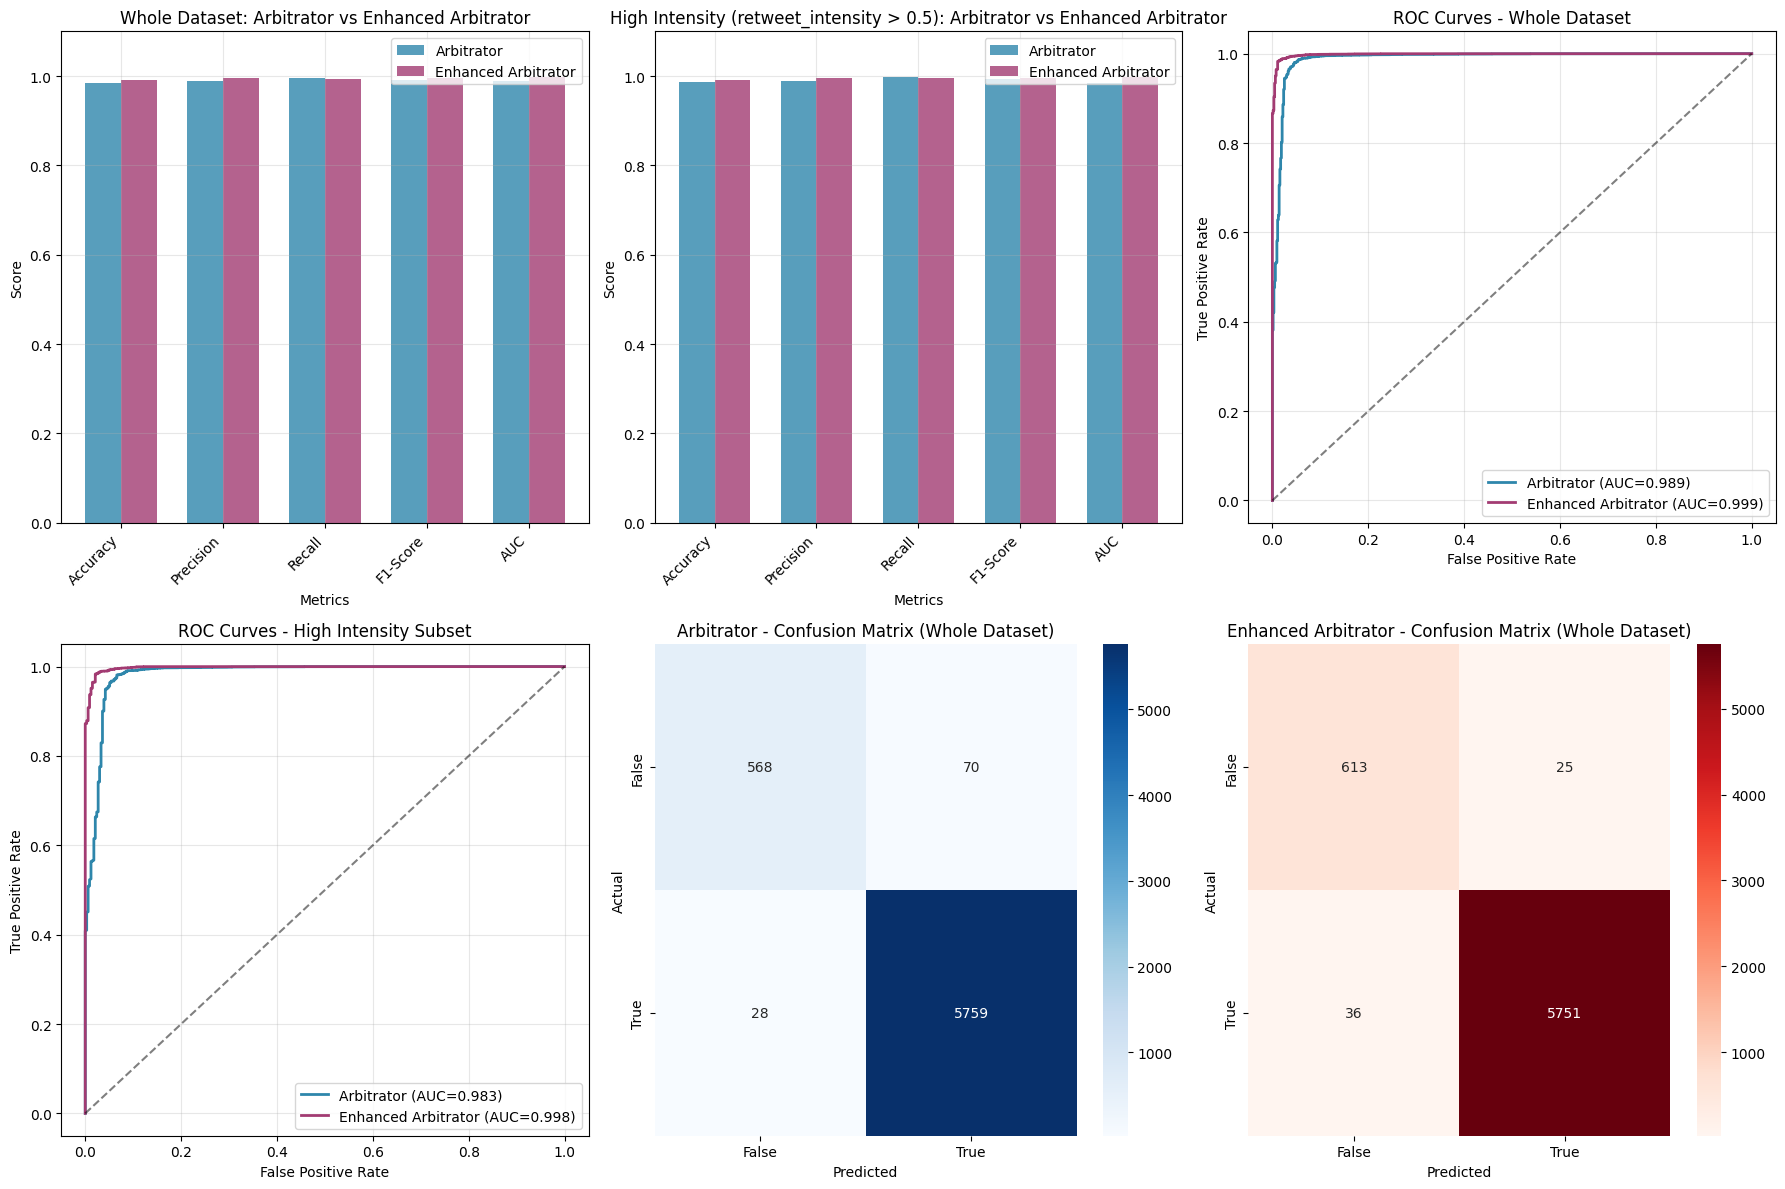

In [14]:
# Create comprehensive comparison visualization
print("\n" + "="*80)
print("Creating Comparison Visualizations")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Whole Dataset - Metrics Comparison
ax = axes[0, 0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(metrics))
width = 0.35

arbitrator_values = [arbitrator_acc, arbitrator_precision, arbitrator_recall, arbitrator_f1, arbitrator_auc]
enhanced_arbitrator_values = [enhanced_arbitrator_acc, enhanced_arbitrator_precision, enhanced_arbitrator_recall, enhanced_arbitrator_f1, enhanced_arbitrator_auc]

ax.bar(x - width/2, arbitrator_values, width, label='Arbitrator', alpha=0.8, color='#2E86AB')
ax.bar(x + width/2, enhanced_arbitrator_values, width, label='Enhanced Arbitrator', alpha=0.8, color='#A23B72')
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Whole Dataset: Arbitrator vs Enhanced Arbitrator')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.1])

# 2. High Intensity Subset - Metrics Comparison
ax = axes[0, 1]
arbitrator_values_high = [arbitrator_acc_high, arbitrator_precision_high, arbitrator_recall_high, arbitrator_f1_high, arbitrator_auc_high]
enhanced_arbitrator_values_high = [enhanced_arbitrator_acc_high, enhanced_arbitrator_precision_high, enhanced_arbitrator_recall_high, enhanced_arbitrator_f1_high, enhanced_arbitrator_auc_high]

ax.bar(x - width/2, arbitrator_values_high, width, label='Arbitrator', alpha=0.8, color='#2E86AB')
ax.bar(x + width/2, enhanced_arbitrator_values_high, width, label='Enhanced Arbitrator', alpha=0.8, color='#A23B72')
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('High Intensity (retweet_intensity > 0.5): Arbitrator vs Enhanced Arbitrator')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.1])

# 3. ROC Curves - Whole Dataset
ax = axes[0, 2]
from sklearn.metrics import roc_curve

fpr_arbitrator, tpr_arbitrator, _ = roc_curve(arbitrator_labels, arbitrator_probs[:, 1])
fpr_enhanced_arbitrator, tpr_enhanced_arbitrator, _ = roc_curve(enhanced_arbitrator_labels, enhanced_arbitrator_probs[:, 1])

ax.plot(fpr_arbitrator, tpr_arbitrator, label=f'Arbitrator (AUC={arbitrator_auc:.3f})', linewidth=2, color='#2E86AB')
ax.plot(fpr_enhanced_arbitrator, tpr_enhanced_arbitrator, label=f'Enhanced Arbitrator (AUC={enhanced_arbitrator_auc:.3f})', linewidth=2, color='#A23B72')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - Whole Dataset')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. ROC Curves - High Intensity
ax = axes[1, 0]
fpr_arbitrator_high, tpr_arbitrator_high, _ = roc_curve(arbitrator_labels_high, arbitrator_probs_high[:, 1])
fpr_enhanced_arbitrator_high, tpr_enhanced_arbitrator_high, _ = roc_curve(enhanced_arbitrator_labels_high, enhanced_arbitrator_probs_high[:, 1])

ax.plot(fpr_arbitrator_high, tpr_arbitrator_high, label=f'Arbitrator (AUC={arbitrator_auc_high:.3f})', linewidth=2, color='#2E86AB')
ax.plot(fpr_enhanced_arbitrator_high, tpr_enhanced_arbitrator_high, label=f'Enhanced Arbitrator (AUC={enhanced_arbitrator_auc_high:.3f})', linewidth=2, color='#A23B72')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - High Intensity Subset')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Confusion Matrix - Arbitrator (Whole Dataset)
ax = axes[1, 1]
cm_arbitrator = confusion_matrix(arbitrator_labels, arbitrator_predictions)
sns.heatmap(cm_arbitrator, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['False', 'True'], yticklabels=['False', 'True'])
ax.set_title('Arbitrator - Confusion Matrix (Whole Dataset)')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

# 6. Confusion Matrix - Enhanced Arbitrator (Whole Dataset)
ax = axes[1, 2]
cm_enhanced_arbitrator = confusion_matrix(enhanced_arbitrator_labels, enhanced_arbitrator_predictions)
sns.heatmap(cm_enhanced_arbitrator, annot=True, fmt='d', cmap='Reds', ax=ax,
            xticklabels=['False', 'True'], yticklabels=['False', 'True'])
ax.set_title('Enhanced Arbitrator - Confusion Matrix (Whole Dataset)')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

plt.tight_layout()
plt.savefig(os.path.join(ROOT_DIR, 'model/arbitrator/arbitrator_vs_adm_comparison.png'), dpi=300, bbox_inches='tight')
print(f"\n✓ Comparison visualization saved to: model/arbitrator/arbitrator_vs_adm_comparison.png")
plt.show()


In [16]:
# Summary Table
print("\n" + "="*80)
print("SUMMARY: Arbitrator vs Enhanced Arbitrator Model Comparison")
print("="*80)

summary_data = {
    'Dataset': ['Whole Dataset', 'Whole Dataset', 'High Intensity (>0.5)', 'High Intensity (>0.5)'],
    'Model': ['Arbitrator', 'Enhanced Arbitrator', 'Arbitrator', 'Enhanced Arbitrator'],
    'Accuracy': [arbitrator_acc, enhanced_arbitrator_acc, arbitrator_acc_high, enhanced_arbitrator_acc_high],
    'Precision': [arbitrator_precision, enhanced_arbitrator_precision, arbitrator_precision_high, enhanced_arbitrator_precision_high],
    'Recall': [arbitrator_recall, enhanced_arbitrator_recall, arbitrator_recall_high, enhanced_arbitrator_recall_high],
    'F1-Score': [arbitrator_f1, enhanced_arbitrator_f1, arbitrator_f1_high, enhanced_arbitrator_f1_high],
    'AUC': [arbitrator_auc, enhanced_arbitrator_auc, arbitrator_auc_high, enhanced_arbitrator_auc_high]
}

summary_df = pd.DataFrame(summary_data)
print("\nComplete Comparison Table:")
print(summary_df.round(4))

# Calculate improvements
print("\n" + "="*80)
print("Performance Differences (Arbitrator - Enhanced Arbitrator)")
print("="*80)

diff_whole = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
    'Whole Dataset': [
        arbitrator_acc - enhanced_arbitrator_acc,
        arbitrator_precision - enhanced_arbitrator_precision,
        arbitrator_recall - enhanced_arbitrator_recall,
        arbitrator_f1 - enhanced_arbitrator_f1,
        arbitrator_auc - enhanced_arbitrator_auc
    ],
    'High Intensity (>0.5)': [
        arbitrator_acc_high - enhanced_arbitrator_acc_high,
        arbitrator_precision_high - enhanced_arbitrator_precision_high,
        arbitrator_recall_high - enhanced_arbitrator_recall_high,
        arbitrator_f1_high - enhanced_arbitrator_f1_high,
        arbitrator_auc_high - enhanced_arbitrator_auc_high
    ]
}

diff_df = pd.DataFrame(diff_whole)
print(diff_df.round(4))

# Highlight best model
print("\n" + "="*80)
print("Best Model by Metric")
print("="*80)

best_models = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
    'Whole Dataset': [
        'Arbitrator' if arbitrator_acc > enhanced_arbitrator_acc else 'Enhanced Arbitrator',
        'Arbitrator' if arbitrator_precision > enhanced_arbitrator_precision else 'Enhanced Arbitrator',
        'Arbitrator' if arbitrator_recall > enhanced_arbitrator_recall else 'Enhanced Arbitrator',
        'Arbitrator' if arbitrator_f1 > enhanced_arbitrator_f1 else 'Enhanced Arbitrator',
        'Arbitrator' if arbitrator_auc > enhanced_arbitrator_auc else 'Enhanced Arbitrator'
    ],
    'High Intensity (>0.5)': [
        'Arbitrator' if arbitrator_acc_high > enhanced_arbitrator_acc_high else 'Enhanced Arbitrator',
        'Arbitrator' if arbitrator_precision_high > enhanced_arbitrator_precision_high else 'Enhanced Arbitrator',
        'Arbitrator' if arbitrator_recall_high > enhanced_arbitrator_recall_high else 'Enhanced Arbitrator',
        'Arbitrator' if arbitrator_f1_high > enhanced_arbitrator_f1_high else 'Enhanced Arbitrator',
        'Arbitrator' if arbitrator_auc_high > enhanced_arbitrator_auc_high else 'Enhanced Arbitrator'
    ]
}

best_df = pd.DataFrame(best_models)
print(best_df)

print("\n" + "="*80)
print("Evaluation Complete!")
print("="*80)



SUMMARY: Arbitrator vs Enhanced Arbitrator Model Comparison

Complete Comparison Table:
                 Dataset                Model  Accuracy  Precision  Recall  \
0          Whole Dataset           Arbitrator    0.9847     0.9880  0.9952   
1          Whole Dataset  Enhanced Arbitrator    0.9905     0.9957  0.9938   
2  High Intensity (>0.5)           Arbitrator    0.9873     0.9898  0.9968   
3  High Intensity (>0.5)  Enhanced Arbitrator    0.9916     0.9960  0.9950   

   F1-Score     AUC  
0    0.9916  0.9890  
1    0.9947  0.9985  
2    0.9933  0.9833  
3    0.9955  0.9979  

Performance Differences (Arbitrator - Enhanced Arbitrator)
      Metric  Whole Dataset  High Intensity (>0.5)
0   Accuracy        -0.0058                -0.0043
1  Precision        -0.0077                -0.0062
2     Recall         0.0014                 0.0017
3   F1-Score        -0.0032                -0.0023
4        AUC        -0.0096                -0.0145

Best Model by Metric
      Metric        Wh